In [242]:
import time, collections, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.io.image import read_image
#from torchvision.transforms import ToPILImage
#from torchvision.transforms.functional import normalize, resize, to_pil_image

# !pip install grad-cam
from pytorch_grad_cam import GradCAM, EigenGradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

#!pip install torchcam
#from torchcam.methods import SmoothGradCAMpp

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla P100-PCIE-16GB


In [15]:
EPOCHS = 5
BATCH_SIZE = 32
NUM_CLASSES = 196

model = models.resnet18(pretrained=True)
nb_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(nb_ftrs, NUM_CLASSES)
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
dataset_dir = "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/"

# Apply some data_augmentation
train_tfms = transforms.Compose([transforms.Resize((256, 256)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_tfms = transforms.Compose([transforms.Resize((256, 256)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset = torchvision.datasets.ImageFolder(root=dataset_dir+"train", transform = train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True)

dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir+"test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size = BATCH_SIZE, shuffle=False)

In [17]:
def train_model(model, criterion, optimizer, scheduler):
    losses = []
    accuracies = []
    test_accuracies = []
    
    model.train()
    model=model.to('cuda')
    for epoch in range(EPOCHS):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
            inputs, labels = data
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
                
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()

        epoch_duration = time.time() - since
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 / BATCH_SIZE * running_correct / len(trainloader)
        print("duration: %d s, epoch %s, loss: %.4f, accuracy: %.4f" % (epoch_duration, epoch+1, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        model.eval()
        test_acc = eval_mode(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    return model

In [18]:
def eval_mode(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_acc = 100.0 * correct / total
    return test_acc

In [20]:
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
trained_model = train_model(model, criterion, optimizer, lrscheduler)

  3%|▎         | 8/255 [00:02<01:28,  2.78it/s]

KeyboardInterrupt



In [195]:
# Get misclassified examples

# Assume model, test_loader and device are already defined
model.eval()  # Set the model to evaluation mode
to_pil = ToPILImage()

misclassified_examples = []

with torch.no_grad():  # No need to track gradients
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        
        # Check for misclassifications
        misclassifications = predictions != labels
        for image, label, prediction in zip(images[misclassifications], labels[misclassifications], predictions[misclassifications]):
            misclassified_examples.append((image.cpu(), label.cpu(), prediction.cpu()))
            

# Assuming misclassified_examples is a list of tuples (image, true_label, predicted_label)
error_counts = collections.Counter()
for _, true_label, _ in misclassified_examples:
    error_counts[true_label.item()] += 1
    
# Convert the counter to a DataFrame
error_df = pd.DataFrame(list(error_counts.items()), columns=['Class', 'Error Count'])
error_df = error_df.sort_values(by="Error Count", ascending=False)
error_df['Class_name'] = error_df['Class'].apply(lambda x : dataset2.classes[x])

error_df

Class  Error Count                                 Class_name
40      40           41          Bentley Continental GT Coupe 2007
69      69           38  Chevrolet Silverado 1500 Regular Cab 2012
11      11           37                        Audi 100 Sedan 1994
36      36           35                            BMW X6 SUV 2012
101    101           34              Ferrari 458 Italia Coupe 2012
..     ...          ...                                        ...
159    159            2                 McLaren MP4-12C Coupe 2012
102    102            2        Ferrari California Convertible 2012
98      98            1                       FIAT 500 Abarth 2012
157    157            1         Maybach Landaulet Convertible 2012
105    105            1               Ford E-Series Wagon Van 2012

[196 rows x 3 columns]

In [205]:
def get_all_files_from_class(class_name):
    folder_path = os.path.join("/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/", class_name + "/")
    file_names = os.listdir(folder_path)
    return file_names

In [229]:
def get_gradiant_cam_of_model(class_name):
    cam_images = []

    target_layers = [trained_model.layer4]
    targets = [ClassifierOutputTarget(195)]
    cam = EigenGradCAM(model=model, target_layers=target_layers)

    file_names = get_all_files_from_class(class_name)
    
    for file in file_names:
        image_path = "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/" + class_name + "/" + file 

        img = np.array(Image.open(image_path))
        img = cv2.resize(img, (224, 224))
        img = np.float32(img) / 255

        input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
        grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
        cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)

        cam_images.append(cam_image)

    max_images_per_row = 6
    for i in range(0, len(cam_images), max_images_per_row):
        images_row = cam_images[i:i+max_images_per_row]
        row_image = np.hstack(images_row)
        display(Image.fromarray(row_image))

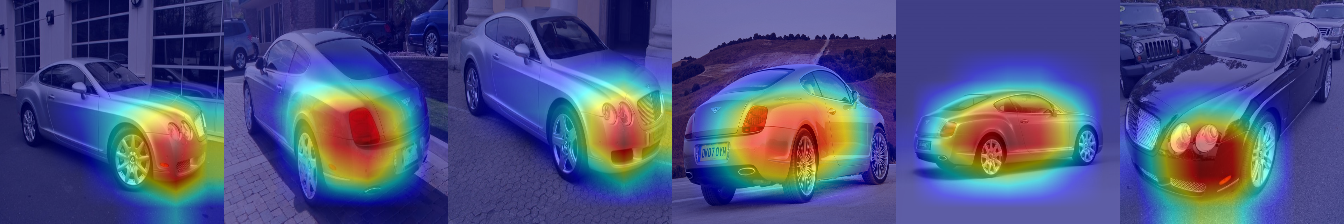

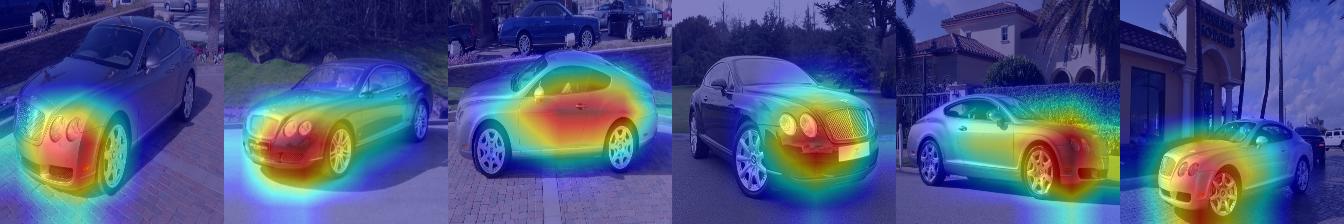

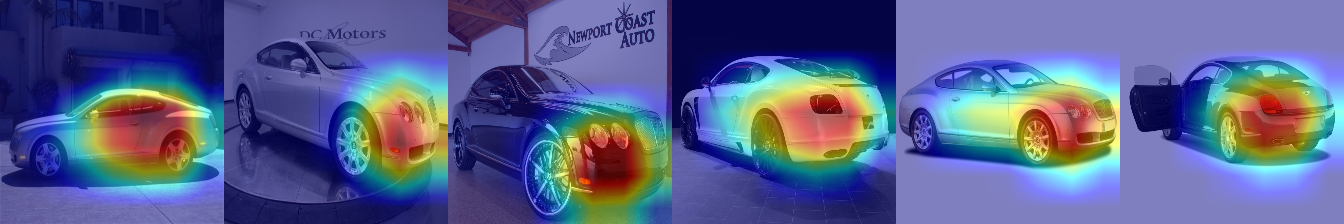

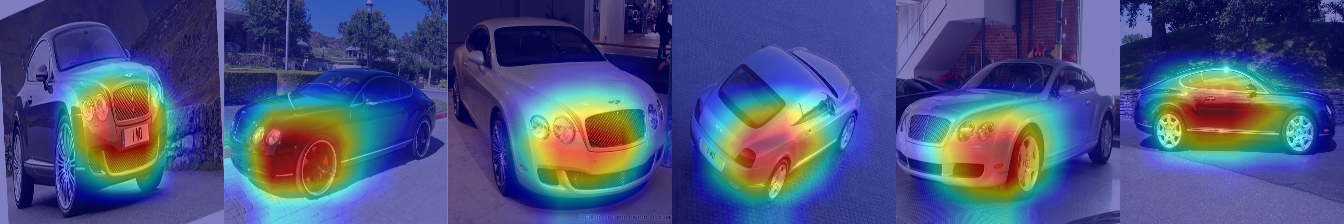

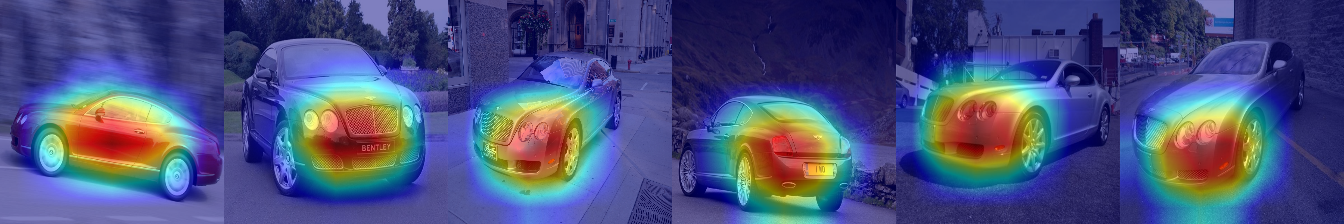

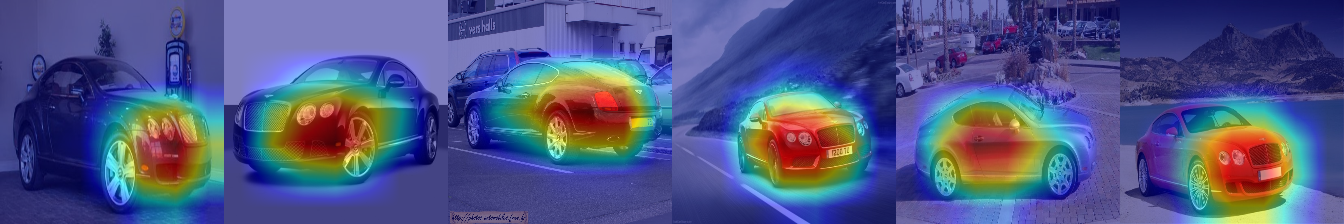

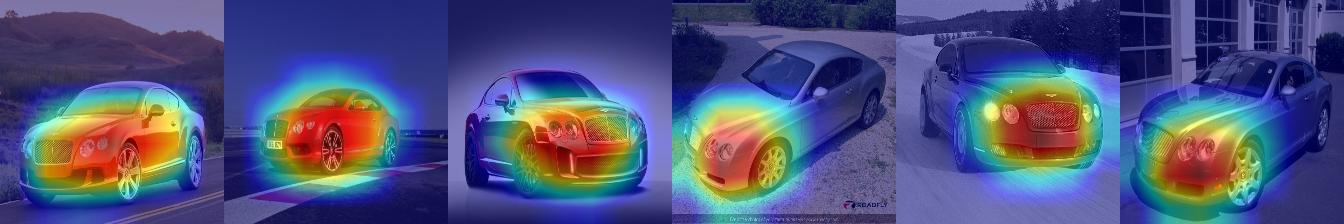

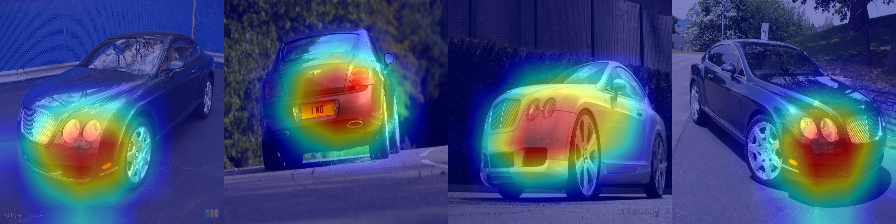

In [230]:
#get_gradiant_cam_of_model("AM General Hummer SUV 2000")
get_gradiant_cam_of_model("Bentley Continental GT Coupe 2007")

In [241]:
img = read_image("/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/AM General Hummer SUV 2000/00163.jpg")
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

with SmoothGradCAMpp(model) as cam_extractor:
    out = model(input_tensor.unsqueeze(0))
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


RuntimeError: cannot register a hook on a tensor that doesn't require gradient